In [1]:
from fastai import *
from fastbook import *

#Getting the dataset
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path

/home/lucien/anaconda3/lib/python3.7/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


Path('.')

In [2]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [3]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [5]:
#printing an image 
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
#converting the image into tensor 
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[0:27,0:27])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0


In [7]:
im3_t.shape

torch.Size([28, 28])

In [8]:
#Idea for first classifier (naive) 
#Get the "mean" of each digit and classify as the most similar one. 

#Creating list of tensors for data 
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

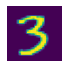

In [9]:
show_image(three_tensors[1])

In [10]:
#Stacking the tensors into 3D tensor and normalizing pixels. 
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens.shape

torch.Size([6265, 28, 28])

<AxesSubplot:>

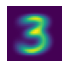

In [11]:
#mean of 3 
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

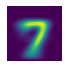

In [12]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

# How can we measure the difference between two pictures in this context ? 

Often we will take the mean of absolute values of differences between pixels (MAE == L1 NORM)) OR take the mean square of differences (RMSE == L2 NORM)

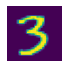

In [13]:
#Trying on a sample image 
a_3 = stacked_threes[1]
show_image(a_3);

In [14]:
#distance from threes
l1norm = (a_3 - mean3).abs().mean()
l2norm = ((a_3 - mean3)**2).mean().sqrt()
l1norm, l2norm

(tensor(0.1114), tensor(0.2021))

In [15]:
#distance from sevens 
l1norm = (a_3 - mean7).abs().mean()
l2norm = ((a_3 - mean7)**2).mean().sqrt()
l1norm, l2norm

(tensor(0.1586), tensor(0.3021))

In [16]:
#or use pytorch functions for it
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [23]:
#Creating a tensor 
data = [[1,2],[3,4]]

#Numpy array 
arr = array(data)

#Pytorch tensor 
tns = tensor(data)

In [24]:
tns

tensor([[1, 2],
        [3, 4]])

# Some data selections examples

Note: tensors work almost like np arrays

In [18]:
#row 
tns[1]

tensor([3, 4])

In [19]:
#col
tns[:,1]

tensor([2, 4])

In [22]:
#slice syntax 
tns[0:2,0:1]

tensor([[1],
        [3]])

# Using operations on tensors + choosing type

In [25]:
tns + 1

tensor([[2, 3],
        [4, 5]])

In [26]:
tns * 2

tensor([[2, 4],
        [6, 8]])

In [27]:
tns * tns

tensor([[ 1,  4],
        [ 9, 16]])

In [29]:
tns.type()

'torch.LongTensor'

In [31]:
#to float ? 
tns = tns.float()

In [32]:
tns.sqrt()

tensor([[1.0000, 1.4142],
        [1.7321, 2.0000]])

In [33]:
tns.mean()

tensor(2.5000)

In [37]:
tns.norm(1), tns.norm(2)

(tensor(10.), tensor(5.4772))

In [38]:
tns = tns.long()

In [39]:
tns

tensor([[1, 2],
        [3, 4]])

# Opening the validation data 

In [40]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [43]:
#write a function that returns the l1 norm. 
def l1(t1,t2):
    res = (t1-t2).abs().mean((-1,-2))
    return res 
l1(a_3, mean3)

tensor(0.1114)

In [45]:
#use that function on the tensors of valid to get results 
valid_3_dist = l1(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1456, 0.1290, 0.1356,  ..., 0.1133, 0.1151, 0.1358]),
 torch.Size([1010]))

In [46]:
valid_3_tens.shape, mean3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))